Pipeline 1: Thu thập Dữ liệu và Tiền xử lý ban đầu

In [55]:
# Import các thư viện cần thiết
import os  
import fitz  
import pandas as pd  
from sklearn.preprocessing import LabelEncoder  
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from sklearn.model_selection import train_test_split 
from sklearn.utils.class_weight import compute_class_weight  

# Trích xuất văn bản từ một file PDF
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)  
    return " ".join([page.get_text() for page in document])  

In [56]:
# Trích xuất văn bản từ tất cả các file PDF trong thư mục và lưu vào CSV
pdf_folder = "C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/CV"
data = [{"filename": pdf_file, "content": extract_text_from_pdf(os.path.join(pdf_folder, pdf_file))} for pdf_file in os.listdir(pdf_folder)]
pd.DataFrame(data).to_csv("cv_texts.csv", index=False)  # Tạo DataFrame từ danh sách và lưu vào CSV

In [57]:
# Tải và chuẩn hóa dữ liệu từ các file CSV
def load_and_standardize_csv(file_path, text_col, label_col=None, default_label=0):
    df = pd.read_csv(file_path)
    df['text'] = df[text_col]
    df['label'] = df[label_col] if label_col else default_label
    return df[['text', 'label']]

category_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_category_data.csv", 'category')
encoded_category_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_encoded_category_data.csv", 'category', 'encoded_category')
jobs_classify_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_jobs_classify_data.csv", 'text', 'category')
jobs_skills_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_jobs_skills_data.csv", 'skills', 'category')
resume_skills_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_resume_skills_data.csv", 'Resume', 'Category')
new_skills_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_new_skills_data.csv", 'skills')
skill_set_df = load_and_standardize_csv("C:/Users/pngoc/Downloads/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_skill_set_data.csv", 'skills')

combined_df = pd.concat([category_df, encoded_category_df, jobs_classify_df, jobs_skills_df, resume_skills_df, new_skills_df, skill_set_df], ignore_index=True).dropna()

In [58]:
# Chuyển đổi các label sang giá trị số
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'].astype(str))

# Xử lý văn bản và chia dữ liệu
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_df['text'])
X = pad_sequences(tokenizer.texts_to_sequences(combined_df['text']), maxlen=100)
y = combined_df['label'].values.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Tính trọng số của các lớp
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

Pipeline 2: Xây dụng và huấn luyện mô hình

In [60]:
# Import các thư viện cần thiết
from tensorflow.keras.models import Sequential  # Xây dựng các mô hình tuần tự (sequential models) của Keras
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional  # Các lớp của Keras để xây dựng mô hình deep learning
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Cung cấp các callback để điều chỉnh tốc độ học (learning rate) và dừng sớm (early stopping) khi huấn luyện mô hình, kiểu mô hình không hiệu quả thì nó sẽ dừng

model = Sequential()  # Khởi tạo mô hình tuần tự
model.add(Embedding(input_dim=5000, output_dim=128))  # Thêm lớp Embedding để chuyển đổi các từ thành vector số
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Sử dụng Bi-LSTM (LSTM hai chiều) để mô hình học từ cả hai hướng của chuỗi, tăng units
model.add(BatchNormalization())  # Thêm lớp BatchNormalization để chuẩn hóa các đầu ra của lớp trước đó
model.add(Dropout(0.4))  # Giảm dropout một chút
model.add(LSTM(128, return_sequences=True))  # Thêm một lớp LSTM nữa để tăng độ phức tạp
model.add(Dropout(0.4))
model.add(GRU(128))  # Tăng units của lớp GRU
model.add(BatchNormalization())  # Thêm lớp BatchNormalization để chuẩn hóa các đầu ra của lớp trước đó
model.add(Dropout(0.4))  # Giảm dropout một chút
model.add(Dense(256, activation='relu'))  # Tăng units của lớp Dense
model.add(Dropout(0.4))  # Giảm dropout một chút
model.add(Dense(len(le.classes_), activation='softmax'))  # Thêm lớp Dense cuối cùng với hàm kích hoạt softmax để phân loại đầu ra

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)  # Callback để giảm tốc độ học khi độ lỗi không giảm
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Callback để dừng sớm nếu độ lỗi không giảm sau một số lần huấn luyện

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Biên dịch mô hình với hàm mất mát (loss function) và trình tối ưu hóa (optimizer)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping], class_weight=class_weights_dict)  # Huấn luyện mô hình với dữ liệu huấn luyện và các callback đã thiết lập, tăng số lượng epochs

Epoch 1/20
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 1463s 1s/step - accuracy: 0.0606 - loss: 6.0337 - val_accuracy: 0.0088 - val_loss: 4.6739 - learning_rate: 0.0010
Epoch 2/20
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 1472s 1s/step - accuracy: 0.1172 - loss: 5.5414 - val_accuracy: 3.3602e-04 - val_loss: 6.0188 - learning_rate: 0.0010
Epoch 3/20
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 1228s 1s/step - accuracy: 0.0900 - loss: 5.4855 - val_accuracy: 0.5085 - val_loss: 3.4244 - learning_rate: 0.0010
Epoch 4/20
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 1214s 1s/step - accuracy: 0.0557 - loss: 5.2141 - val_accuracy: 3.3602e-04 - val_loss: 6.1127 - learning_rate: 0.0010
Epoch 5/20
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 1676s 2s/step - accuracy: 0.0815 - loss: 4.9835 - val_accuracy: 0.0048 - val_loss: 5.2934 - learning_rate: 0.0010
Epoch 6/20
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 1557s 1s/step - accuracy: 0.1111 - loss: 4.9116 - val_accuracy: 0.0149 - val_loss: 4.2312 - learning_rate: 2.0000e-04


In [51]:
# Demo quy trình dự đoán điểm CV
def predict_matching_score(cv_text):
    cv_seq = tokenizer.texts_to_sequences([cv_text])  
    cv_pad = pad_sequences(cv_seq, maxlen=100) 
    score = model.predict(cv_pad)  
    matching_percentage = score.max() * 10000  
    return matching_percentage

# Ví dụ
new_cv_text = extract_text_from_pdf(r"C:\Users\pngoc\Downloads\Smart-Talent-Resume-Ranker-kapil-development\Smart-Talent-Resume-Ranker-kapil-development\CV\nikhilkumar9917103088 - Nikhil kumar.pdf")  
matching_score = predict_matching_score(new_cv_text)  
print(f"Matching Score: {matching_score:.2f}%")  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Matching Score: 84.32%


Pipeline 3: Đánh giá mô hình dựa trên Precision và Recall

Matplotlib is building the font cache; this may take a moment.


279/279 ━━━━━━━━━━━━━━━━━━━━ 156s 544ms/step
Precision: 0.8208010499814762
Recall: 0.023984173340252834


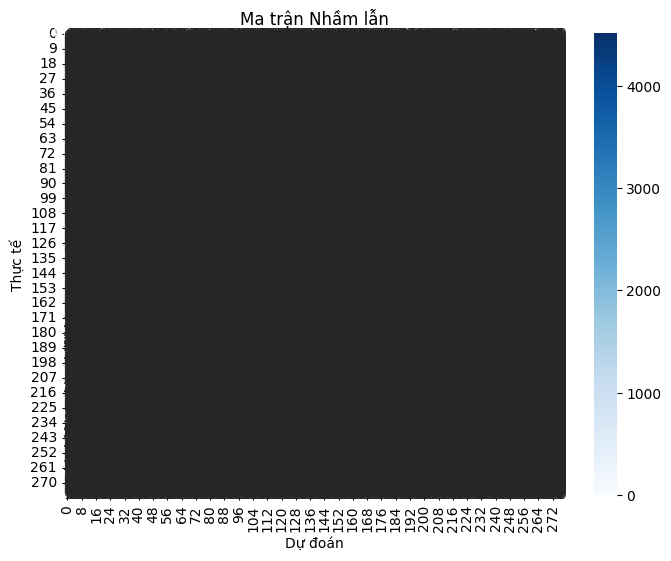

In [65]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).argmax(axis=1)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận Nhầm lẫn')
plt.show()
